Imports

In [1]:
# Pytorch
import torch
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

# Utils
import neptune
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from dataclasses import dataclass
from IPython.display import display, clear_output
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

GPU Management

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'

In [3]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

In [4]:
print("__OS DETAILS:", os.uname())
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__)
print("__CUDA VERSION:")
! nvidia-smi
print("__CUDNN VERSION:", torch.backends.cudnn.version())
!nvcc --version
print("__Number CUDA Devices:", torch.cuda.device_count())
print("__Devices")
print("Active CUDA Device: GPU", torch.cuda.current_device())
print("Available devices ", torch.cuda.device_count())
print("Current cuda device ", torch.cuda.current_device())

__OS DETAILS: posix.uname_result(sysname='Linux', nodename='pdconte-localhost', release='6.10.6-2-liquorix-amd64', version='#1 ZEN SMP PREEMPT liquorix 6.10-6ubuntu1~jammy (2024-08-20)', machine='x86_64')
__Python VERSION: 3.12.3 (main, Sep  4 2024, 12:08:24) [GCC 13.2.0]
__pyTorch VERSION: 2.4.1+cu124
__CUDA VERSION:
Wed Sep 11 19:07:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   

In [5]:
@dataclass
class Params:
    images_dir: str = "./X_train_corrected/images"
    labels_csv: str = "./y_train_PlZf4rH.csv"
    test_images_dir: str = "./X_test_Xqv4sJa/images"
    image_shape: tuple = (36, 36)
    image_reshape: tuple = (32, 32)
    batch_size: int = 128
    true_boolean: bool = True
    false_boolean: bool = False
    num_workers: int = 0
    channels: int = 1
    classes: int = 1
    encoder_name: str = "resnet152"
    encoder_weights: str = "imagenet"
    decoder: str = "Yes"
    decoder_attention_type: str | None = "scse" if decoder == "Yes" else None
    activation: str = "No"
    activation_layer: str | None = "sigmoid" if activation == "Yes" else None
    compile_mode: str = "default"
    num_epochs: int = 5
    learning_rate: float = 1e-3
    max_grad_norm: float = 1.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

Data Loader

In [6]:
# Function to get the well ID from the image name
def get_well_id(img_name):
    return int(img_name.split("_")[1])

In [7]:
class WellDataset(Dataset):
    def __init__(self, transform=None, exclude_wells=None):
        if exclude_wells is None:
            exclude_wells = []
        self.images_dir = Params.images_dir
        self.labels_df = pd.read_csv(Params.labels_csv, index_col=0)

        # Filter out specific wells
        self.labels_df = self.labels_df.loc[
            [
                img_name
                for img_name in self.labels_df.index
                if get_well_id(img_name) not in exclude_wells
            ]
        ]

        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.index[idx]
        image_path = f"{self.images_dir}/{img_name}.npy"
        image = np.load(image_path)
        label = (
            self.labels_df.loc[img_name]
            .values.reshape(Params.image_shape)
            .astype("float32")
        )

        # Check for NaNs and replace them with zeros
        image = np.nan_to_num(image)
        label = np.nan_to_num(label)

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return img_name, image, label

In [8]:
transform = transforms.Compose(
    [
        transforms.Resize(Params.image_reshape),
        # transforms.Normalize(mean=[0.485], std=[0.229]),
    ]
)

In [9]:
# # Define wells for training and validation
# train_wells = [1, 2, 4, 5, 8, 9, 12, 13, 14] #,15]
# val_wells = [3, 6, 7, 10, 11]

# Load the dataset
dataset = WellDataset(transform=transform)

# Get well IDs for all images
well_ids = [get_well_id(img_name) for img_name in dataset.labels_df.index]

# Use Counter to check patch distribution across wells
well_counts = Counter(well_ids)
print("Well counts:", well_counts)

Well counts: Counter({13: 1905, 3: 1774, 7: 1654, 11: 1512, 6: 964, 2: 616, 14: 355, 15: 203, 1: 166, 9: 166, 5: 98, 10: 80, 8: 78, 4: 59, 12: 44})


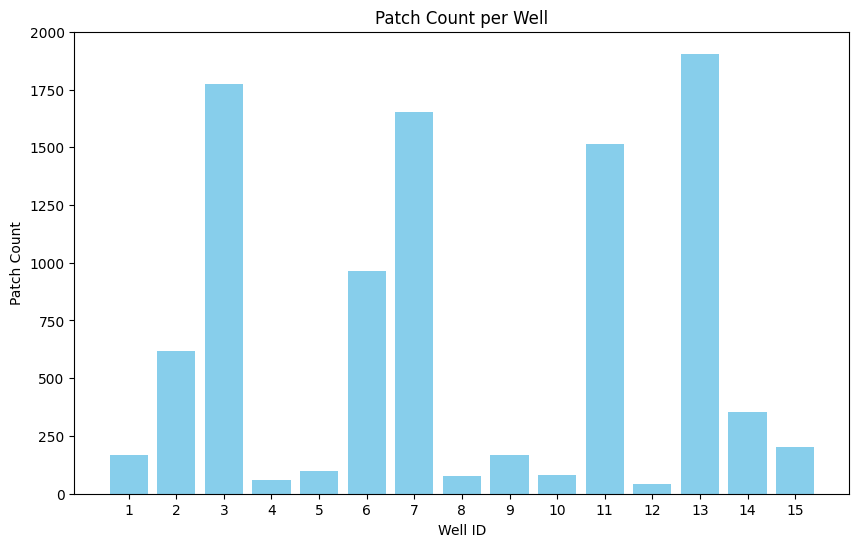

In [10]:
# Extract well IDs and their corresponding counts
wells = list(well_counts.keys())
counts = list(well_counts.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(wells, counts, color="skyblue")

# Add labels and title
plt.xlabel("Well ID")
plt.ylabel("Patch Count")
plt.title("Patch Count per Well")
plt.xticks(wells)  # Show well IDs as x-axis ticks

# Show the plot
plt.show()

In [11]:
# Convert well IDs to numpy array for StratifiedKFold
well_ids = [well_id for well_id in well_ids if well_id != 15]
well_ids = np.array(well_ids)
# Perform stratified split with desired proportions
stratified_split = StratifiedKFold(n_splits=5, shuffle=True)

# Get the first split for train and validation sets
for train_idx, val_idx in stratified_split.split(np.zeros(len(well_ids)), well_ids):
    break

# Create the train and validation datasets
train_dataset = Subset(WellDataset(transform=transform, exclude_wells=[15]), train_idx)
val_dataset = Subset(WellDataset(transform=transform, exclude_wells=[15]), val_idx)

# Output the sizes of the datasets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 7576
Validation set size: 1895


In [12]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=Params.batch_size,
    shuffle=Params.true_boolean,
    num_workers=Params.num_workers,
    pin_memory=Params.true_boolean,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=Params.batch_size,
    shuffle=Params.false_boolean,
    num_workers=Params.num_workers,
    pin_memory=Params.true_boolean,
)

In [13]:
train_value_counter = Counter()
val_value_counter = Counter()

# Loop through the train DataLoader to extract pixel values
for _, images, _ in tqdm(train_loader):
    # Flatten the images to create a 1D array of all pixel values
    flattened_images = images.cpu().numpy().flatten()
    train_value_counter.update(flattened_images)

# Loop through the val DataLoader to extract pixel values
for _, images, _ in tqdm(val_loader):
    # Flatten the images to create a 1D array of all pixel values
    flattened_images = images.cpu().numpy().flatten()
    val_value_counter.update(flattened_images)

# Display the most common pixel values for train and val
train_most_common_values = train_value_counter.most_common(20)
val_most_common_values = val_value_counter.most_common(20)

print("Most common pixel values in training:", train_most_common_values)
print("Most common pixel values in validation:", val_most_common_values)

# Function to determine if a value is a default value based on criteria
def is_default_value(value, threshold=-998.0):
    return value <= threshold


# Extract default values from train and val common values
train_default_values = [
    float(val) for val, count in train_most_common_values if is_default_value(val)
]
val_default_values = [
    float(val) for val, count in val_most_common_values if is_default_value(val)
]

# Merge both lists and get unique default values
default_values = list(set(train_default_values + val_default_values))

print("Default values detected:", default_values)

100%|██████████| 15/15 [00:01<00:00,  9.08it/s]


Most common pixel values in training: [(np.float32(-999.2499), 12116), (np.float32(-999.24994), 11405), (np.float32(-998.9999), 6197), (np.float32(-998.99994), 3186), (np.float32(-999.0), 1488), (np.float32(-0.01751561), 1122), (np.float32(-999.25), 574), (np.float32(-0.017515609), 467), (np.float32(-0.0031377221), 158), (np.float32(-0.012903972), 158), (np.float32(-0.0019819508), 141), (np.float32(-0.007561739), 136), (np.float32(-0.0027884839), 135), (np.float32(-0.010151794), 135), (np.float32(-0.011802452), 135), (np.float32(-0.0043994337), 135), (np.float32(-0.0019005684), 131), (np.float32(0.00043340618), 130), (np.float32(0.01014927), 130), (np.float32(0.0021405995), 119)]
Most common pixel values in validation: [(np.float32(-999.2499), 2213), (np.float32(-999.24994), 2068), (np.float32(-998.9999), 580), (np.float32(-998.99994), 301), (np.float32(-999.0), 144), (np.float32(-999.25), 108), (np.float32(-8.940696e-08), 25), (np.float32(0.0080257505), 25), (np.float32(-0.008765539),

Model

In [14]:
model = smp.Unet(
    encoder_name=Params.encoder_name,
    encoder_weights=Params.encoder_weights,
    in_channels=Params.channels,
    decoder_attention_type=Params.decoder_attention_type,
    classes=Params.classes,
    activation=Params.activation_layer,
)

# model = torch.compile(model, mode=Params.compile_mode)
model.to(Params.device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [15]:
# Print model summary
summary(
    model,
    (Params.channels, *Params.image_reshape),
    batch_size=Params.batch_size,
    device=Params.device,
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 64, 16, 16]           3,136
       BatchNorm2d-2          [128, 64, 16, 16]             128
              ReLU-3          [128, 64, 16, 16]               0
         MaxPool2d-4            [128, 64, 8, 8]               0
            Conv2d-5            [128, 64, 8, 8]           4,096
       BatchNorm2d-6            [128, 64, 8, 8]             128
              ReLU-7            [128, 64, 8, 8]               0
            Conv2d-8            [128, 64, 8, 8]          36,864
       BatchNorm2d-9            [128, 64, 8, 8]             128
             ReLU-10            [128, 64, 8, 8]               0
           Conv2d-11           [128, 256, 8, 8]          16,384
      BatchNorm2d-12           [128, 256, 8, 8]             512
           Conv2d-13           [128, 256, 8, 8]          16,384
      BatchNorm2d-14           [128, 25

In [16]:
criterion = nn.BCEWithLogitsLoss(reduction="none").to(Params.device)
scaler = torch.GradScaler(device=Params.device)
optimizer = optim.Adam(
    params=model.parameters(),
    lr=Params.learning_rate,
    amsgrad=Params.true_boolean,
    weight_decay=Params.learning_rate * 0.1,
    foreach=Params.true_boolean,
)

In [17]:
# scheduler = optim.lr_scheduler.StepLR(
#     optimizer=optimizer, step_size=10, gamma=0.1
# )  # Reduce LR by a factor of 10 every 10 epochs

# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.1,
    patience=5,
)

In [18]:
run = neptune.init_run(
    project="contepablod/UNet",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2YjAzNmM1Zi0yYzM2LTQ1YTUtYjNmYi0xOGQ0NDgwYjY1NzMifQ==",
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
    capture_traceback=True,
)  # Start Neptune Run

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/contepablod/UNet/e/UN-125


In [19]:
def run_epoch(model, loader, optimizer, criterion, mode, device, default_value):
    if mode == "train":
        model.train()
        is_train = True
    else:
        model.eval()
        is_train = False

    running_loss = 0.0
    correct = 0
    total = 0
    nan_count = {"input_images": 0, "input_labels": 0, "outputs": 0, "loss": 0}
    inf_count = {"input_images": 0, "input_labels": 0, "outputs": 0, "loss": 0}

    for img_name, images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        # Check for NaNs and Infs in images and labels
        if torch.isnan(images).any():
            print(f"NaN detected in {mode} input images")
            nan_count["input_images"] += 1
            continue
        if torch.isnan(labels).any():
            print(f"NaN detected in {mode} input labels")
            nan_count["input_labels"] += 1
            continue
        if torch.isinf(images).any():
            print(f"Inf detected in {mode} input images")
            inf_count["input_images"] += 1
            continue
        if torch.isinf(labels).any():
            print(f"Inf detected in {mode} input labels")
            inf_count["input_labels"] += 1
            continue

        # Reset gradients only for training
        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.autocast(device_type=device):
            mask = torch.ones_like(
                images, dtype=torch.bool
            )  # Initialize a mask of all True values

            # Iterate over default values to update the mask
            for default_value in default_values:
                mask &= images != default_value

            outputs = model(images)

        # Check for NaNs and Infs in outputs
        if torch.isnan(outputs).any():
            print(f"NaN detected in {mode} outputs")
            nan_count["outputs"] += 1
            continue
        if torch.isinf(outputs).any():
            print(f"Inf detected in {mode} outputs")
            inf_count["outputs"] += 1
            continue

        loss = criterion(outputs, labels)
        masked_loss = loss * mask

        if torch.isnan(masked_loss).any():
            print(f"NaN detected in {mode} loss")
            nan_count["loss"] += 1
            continue
        if torch.isinf(masked_loss).any():
            print(f"Inf detected in {mode} loss")
            inf_count["loss"] += 1
            continue

        # Normalize the loss by valid points
        valid_points = mask.sum()
        if valid_points > 0:
            masked_loss = masked_loss.sum() / valid_points
        else:
            print(f"No valid points found in {mode}")
            continue

        # Backpropagation only for training
        if is_train:
            scaler.scale(masked_loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=Params.max_grad_norm)
            scaler.step(optimizer)
            scaler.update()

        running_loss += masked_loss.item()

        if is_train:
            run["train/loss"].append(masked_loss.item())
        else:
            run["val/loss"].append(masked_loss.item())

        # Calculate predictions and accuracy
        preds = (torch.sigmoid(outputs) > 0.5).int()
        masked_preds = preds[mask]
        masked_labels = labels[mask]
        correct = (masked_preds == masked_labels).sum().item()
        total = mask.sum().item()

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(loader)
    accuracy = correct / total if total > 0 else 0

    return avg_loss, accuracy, nan_count, inf_count

In [20]:
def train_and_evaluate(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    device,
    default_value,
    num_epochs,
):
    # Initialize lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_nan_count, train_inf_count = {}, {}
    val_nan_count, val_inf_count = {}, {}

    # Initialize plot
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    for epoch in range(num_epochs):
        # Run training epoch
        train_loss, train_accuracy, train_nan_count, train_inf_count = run_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            "train",
            device,
            default_value,
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        run["train/accuracy"].append(train_accuracy)

        # Run validation epoch
        val_loss, val_accuracy, val_nan_count, val_inf_count = run_epoch(
            model,
            val_loader,
            optimizer,
            criterion,
            "val",
            device,
            default_value,
        )
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        run["val/accuracy"].append(val_accuracy)

        # Update learning rate scheduler
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()  # Step for other schedulers

        # Update the plot
        ax1.clear()
        ax2.clear()
        ax1.plot(train_losses, label="Train Loss")
        ax1.plot(val_losses, label="Val Loss")
        ax1.set_title("Loss")
        ax1.legend()

        ax2.plot(train_accuracies, label="Train Accuracy")
        ax2.plot(val_accuracies, label="Val Accuracy")
        ax2.set_title("Accuracy")
        ax2.legend()

        clear_output(wait=True)

        print(
            f"Epoch [{epoch+1}/{num_epochs}]: \
            Train Loss: {train_loss:.4f} \
            Val Loss: {val_loss:.4f} \
            Train Acc: {train_accuracy:.4f} \
            Val Acc: {val_accuracy:.4f}",
            f"\nTrain Nan Count: {train_nan_count}, \
            Val Nan Count: {val_nan_count}, \
            Train Inf Count: {train_inf_count}, \
            Val Inf Count: {val_inf_count}",
        )
        display(fig)

    run.stop()  # Stop Neptune run

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [02:15<00:00,  2.26s/it]


NaN detected in train outputs


  7%|▋         | 1/15 [00:01<00:16,  1.18s/it]

NaN detected in val outputs


 13%|█▎        | 2/15 [00:02<00:15,  1.19s/it]

NaN detected in val outputs


 20%|██        | 3/15 [00:03<00:14,  1.20s/it]

NaN detected in val outputs


 27%|██▋       | 4/15 [00:04<00:13,  1.22s/it]

NaN detected in val outputs


 33%|███▎      | 5/15 [00:06<00:12,  1.22s/it]

NaN detected in val outputs


 40%|████      | 6/15 [00:07<00:11,  1.23s/it]

NaN detected in val outputs


 47%|████▋     | 7/15 [00:08<00:09,  1.23s/it]

NaN detected in val outputs


 47%|████▋     | 7/15 [00:08<00:10,  1.27s/it]


KeyboardInterrupt: 

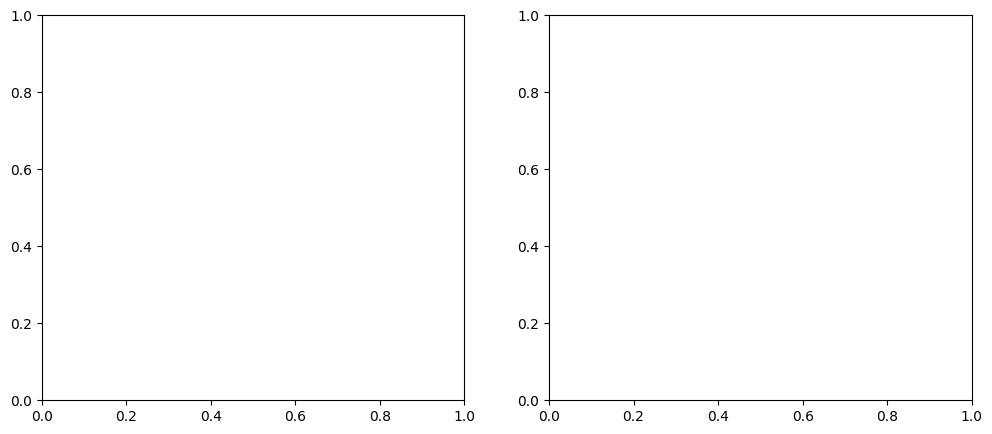

In [21]:
train_and_evaluate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    device=Params.device,
    default_value=default_values,
    num_epochs=Params.num_epochs,
)

Saving

In [21]:
torch.save(model.state_dict(), "model_pretrained.pt")

Testing

In [ ]:
model_test = smp.Unet(
        encoder_name=Params.encoder_name,
        encoder_weights=Params.encoder_weights,
        decoder_attention_type=Params.decoder_attention_type,
        in_channels=Params.channels,
        classes=Params.classes,
        activation=Params.activation_layer,
    )
# model = torch.compile(model, mode=Params.compile_mode)
model_test.load_state_dict(torch.load("model_pretrained.pt", weights_only=True))
model_test.to(Params.device).eval()

In [23]:
def iou_score(preds, labels):
    intersection = (preds * labels).sum()
    union = preds.sum() + labels.sum() - intersection
    return intersection / union

In [ ]:
iou_train_scores = []

with torch.no_grad():
    for _, images, labels in train_loader:
        images, labels = images.to(Params.device), labels.to(Params.device)
        with torch.autocast(device_type=Params.device):
            mask = torch.ones_like(images, dtype=torch.bool)
            for default_value in default_values:
                mask &= images != default_value
            outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).int()
        masked_preds = preds[mask]
        masked_labels = labels[mask]
        iou = iou_score(masked_preds, masked_labels)
        iou_train_scores.append(iou.item())

print(f"Train Mean IoU: {np.mean(iou_train_scores)}")

In [ ]:
iou_val_scores = []

with torch.no_grad():
    for _, images, labels in val_loader:
        images, labels = images.to(Params.device), labels.to(Params.device)
        with torch.autocast(device_type=Params.device):
            mask = torch.ones_like(images, dtype=torch.bool)
            for default_value in default_values:
                mask &= images != default_value
            outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).int()
        masked_preds = preds[mask]
        masked_labels = labels[mask]
        iou = iou_score(masked_preds, masked_labels)
        iou_val_scores.append(iou.item())

print(f"Validation Mean IoU: {np.mean(iou_val_scores)}")

In [26]:
class TestWellDataset(Dataset):
    def __init__(self, transform=None):
        self.images_dir = Params.test_images_dir
        self.image_files = list(sorted(os.listdir(self.images_dir)))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = np.load(f"{self.images_dir}/{img_name}")
        image = np.nan_to_num(image)

        if self.transform:
            image = self.transform(
                torch.tensor(image, dtype=torch.float32).unsqueeze(0)
            )

        # Remove the .npy extension from the image name
        img_name = img_name.replace(".npy", "")

        return img_name, image

In [27]:
# Create the test dataset and dataloader
test_dataset = TestWellDataset(transform=transform)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=Params.batch_size,
    shuffle=Params.false_boolean,
    num_workers=Params.num_workers,
    pin_memory=Params.true_boolean,
)

In [ ]:
test_value_counter = Counter()

for _, images in tqdm(test_loader):
    flattened_images = images.cpu().numpy().flatten()
    test_value_counter.update(flattened_images)

test_most_common_values = train_value_counter.most_common(20)

print("Most common pixel values in training:", test_most_common_values)

test_default_values = [
    float(val) for val, count in test_most_common_values if is_default_value(val)
]

default_values = list(set(default_values + test_default_values))

print("Default values detected:", default_values)

In [ ]:
from scipy.ndimage import zoom

predictions = []
zoom_factors = (1, 36 / 32, 36 / 32)

with torch.no_grad():
    for img_name, images in tqdm(test_loader):
        images = images.to(Params.device)
        with torch.autocast(device_type=Params.device):
            masks = torch.ones_like(images, dtype=torch.bool)
            for default_value in default_values:
                masks &= images != default_value
            outputs = model_test(images)
            pred = (torch.sigmoid(outputs) > 0.5).int()
            # # Iterate over batch
            for i, img_name in enumerate(img_name):
            #     # Resize the output (logits) and mask
            #     # output_resized = zoom(
            #     #     outputs[i].cpu().detach().numpy().astype(np.float32),
            #     #     zoom_factors,
            #     #     order=1,
            #     # )
            #     # mask_resized = zoom(
            #     #     masks[i].cpu().detach().numpy().astype(np.float32),
            #     #     zoom_factors,
            #     #     order=1,
            #     # )
            # Apply sigmoid to get probabilities
            # pred = (torch.sigmoid(torch.tensor(outputs)) > 0.5).int()
            # pred = (torch.sigmoid(outputs) > 0.5).int()

                # Apply the resized mask to zero out predictions corresponding to default value pixels
                # mask_pred = pred[masks]
                # print(mask_pred.shape)

                # Flatten the predictions and save them
                pred_flattened = pred[i].flatten()
                predictions.append([img_name] + pred_flattened.tolist())

# Create column names for the submission file
column_names = [""] + [f"{i}" for i in range(32 * 32)]

# Create a DataFrame and save it to a CSV file in the required submission format
submission_df = pd.DataFrame(predictions, columns=column_names)
submission_df.to_csv("./submission.csv", index=False)